In [3]:
import pandas as pd
import numpy as np 
import scipy.stats as si
import sympy as sy
from sympy.stats import Normal, cdf
import plotly.express as px
from scipy import interpolate
import matplotlib.pyplot as plt

# Load dataset

In [444]:
df = pd.read_excel('./Imply Volatilities From Prices USDJPY Smile.xlsx',sheet_name ="base_final")

# Newton approximation function

In [462]:
def implied_vol(F,K,T,V0,D,sigma_init,option_type):
        
    #F: Foward price
    #K: strike price
    #T: time to maturity
    #D : Discount factor
    #sigma: volatility of underlying asset
    #V0 : Option's initial value
    
    S = F/D
    
    #Black and scholes option pricing: 
    
    d1 = (np.log(F/K) + 0.5* sigma_init**2*T)/(sigma_init*np.sqrt(T))
    d2 = d1- sigma_init*np.sqrt(T) 
    
    if option_type =='Call'or'Call or Put': fx = D*(F*si.norm.cdf(d1,0.0,1.0) - K*si.norm.cdf(d2,0.0, 1.0)) - V0
    if option_type =='Put': fx = D*(K*si.norm.cdf(-d2,0.0,1.0) - F * si.norm.cdf(-d1,0.0, 1.0)) - V0
    
    #Vega of an option price: 
    vega = (1 / np.sqrt(2 * np.pi)) * S * np.sqrt(T) * np.exp(-(si.norm.cdf(d1, 0.0, 1.0) ** 2) * 0.5)
    
    #Newton's Method : 
    epsilon = 0.000001
    x0 = sigma_init
    xnew  = x0
    xold = x0 - 1
        
    while abs(xnew - xold) > epsilon:
    
        xold = xnew
        xnew = (xnew - fx - V0) / vega
        
        return abs(xnew)

In [463]:
for i in range(0,len(df)) : 
    df.sig_est[i] = implied_vol(df.fwrd[i],df.strike[i],df.expiry[i],df.value[i],df.dis[i],0.025,df.Type[i])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [464]:
df

,Type,expiry,fwrd,dis,itm,strike,value,sig_est
0,Put,5,107.193030,0.995012,0.7,75.411236,0.526311,0.000429
1,Put,5,107.193030,0.995012,0.8,86.184270,1.616547,0.000428
2,Put,5,107.193030,0.995012,0.9,96.957303,4.101289,0.000944
3,Put or Call,5,107.193030,0.995012,1.0,107.730337,8.583611,0.024485
4,Call,5,107.193030,0.995012,1.1,118.503371,4.523160,0.000685
5,Call,5,107.193030,0.995012,1.2,129.276405,2.195696,0.000253
6,Call,5,107.193030,0.995012,1.3,140.049438,1.005544,0.000260
7,Put,7,106.871933,0.993024,0.7,75.335863,0.855555,0.000363
8,Put,7,106.871933,0.993024,0.8,86.098129,2.390651,0.000350
9,Put,7,106.871933,0.993024,0.9,96.860395,5.387266,0.002409


In [465]:
table = pd.pivot_table(df, values='sig_est', index=['expiry', 'fwrd'],
                    columns=['itm'], aggfunc=np.sum)

In [466]:
table

,itm,0.7,0.8,0.9,1.0,1.1,1.2,1.3
expiry,fwrd,,,,,,,
5,107.193030,0.000429,0.000428,0.000944,0.024485,0.000685,0.000253,0.000260
7,106.871933,0.000363,0.000350,0.002409,0.023878,0.001494,0.000178,0.000220
10,106.392089,0.000304,0.000206,0.004558,0.023100,0.002579,0.000018,0.000179


# Volatility approximation

In [4]:
df2 = pd.read_excel('./Copie de USDJPY Smile Workshop.xlsx',sheet_name ="base") 
df2

,Type,fwrd,expiry,dis,itm,strike,sigma
0,Put,107.996893,0.019178,0.999981,0.7,75.599275,0.146111
1,Put,107.996893,0.019178,0.999981,0.8,86.399172,0.117273
2,Put,107.996893,0.019178,0.999981,0.9,97.199068,0.097756
3,Call or Put,107.996893,0.019178,0.999981,1.0,107.998964,0.085000
4,Call,107.996893,0.019178,0.999981,1.1,118.798861,0.077286
...,...,...,...,...,...,...,...
72,Put,106.392089,10.000000,0.990050,0.9,96.715213,0.091435
73,Call or Put,106.392089,10.000000,0.990050,1.0,107.461348,0.091435
74,Call,106.392089,10.000000,0.990050,1.1,118.207483,0.091435
75,Call,106.392089,10.000000,0.990050,1.2,128.953617,0.091435


Different interpolation schemes in the strike
direction for ITM = 0.75, 0.85, 0.95, 1.05, 1.15, 1.25 for
each expiry.

In [5]:
itm=df2.itm.unique()
expiry = df2["expiry"].unique()
itm_new = [0.75,0.85,0.95,1.05,1.15,1.25]

In [6]:
for i in range(0,len(expiry)) : 
    globals()['expiry_{0}'.format(i)] = df2.loc[df2.expiry == expiry[i]]
    f_linear = interpolate.interp1d(globals()['expiry_{0}'.format(i)].itm, globals()['expiry_{0}'.format(i)].sigma ,kind='slinear')
    f_quadratic = interpolate.interp1d(globals()['expiry_{0}'.format(i)].itm,globals()['expiry_{0}'.format(i)].sigma ,kind='quadratic')
    f_cubic = interpolate.interp1d(globals()['expiry_{0}'.format(i)].itm,globals()['expiry_{0}'.format(i)].sigma ,kind='cubic')
    ylinear = f_linear(itm_new) 
    yquadratic = f_quadratic(itm_new) 
    ycubic = f_cubic(itm_new)
    globals()['vol_{0}'.format(i)]= pd.DataFrame(list(zip(globals()['expiry_{0}'.format(i)].expiry,itm_new,ylinear,yquadratic,ycubic)),
                   columns =['expiry','itm_new','linear', 'quadratic','cubic'])

In [7]:
frames = [vol_0, vol_1, vol_2,vol_3,vol_4,vol_5,vol_6,vol_7,vol_8,vol_9,vol_10]
result = pd.concat(frames)

In [8]:
result

,expiry,itm_new,linear,quadratic,cubic
0,0.019178,0.75,0.131692,0.130478,0.130355
1,0.019178,0.85,0.107515,0.106497,0.106522
2,0.019178,0.95,0.091378,0.090656,0.090657
3,0.019178,1.05,0.081143,0.080592,0.080596
4,0.019178,1.15,0.075351,0.074933,0.074928
...,...,...,...,...,...
1,10.000000,0.85,0.091435,0.091435,0.091435
2,10.000000,0.95,0.091435,0.091435,0.091435
3,10.000000,1.05,0.091435,0.091435,0.091435
4,10.000000,1.15,0.091435,0.091435,0.091435


In [10]:
linear = pd.pivot_table(result, values='linear', index=['expiry'],
                    columns=['itm_new'], aggfunc=np.sum)
quadratic = pd.pivot_table(result, values='quadratic', index=['expiry'],
                    columns=['itm_new'], aggfunc=np.sum)
cubic = pd.pivot_table(result, values='cubic', index=['expiry'],
                    columns=['itm_new'], aggfunc=np.sum)

In [14]:
import pandas as pd

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('test.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet. you could write different string like above if you want
linear.to_excel(writer, sheet_name='Sheet1')
quadratic.to_excel(writer, sheet_name='Sheet2')
cubic.to_excel(writer, sheet_name='Sheet3')
# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [453]:
linear

itm_new,0.75,0.85,0.95,1.05,1.15,1.25
expiry,,,,,,
0.019178,0.131692,0.107515,0.091378,0.081143,0.075351,0.072973
0.038356,0.127581,0.105822,0.091299,0.082087,0.076874,0.074734
0.082192,0.123898,0.104557,0.091647,0.083459,0.078826,0.076924
0.500000,0.119762,0.102838,0.091542,0.084378,0.080323,0.078659
1.000000,0.115832,0.101325,0.091643,0.085502,0.082027,0.080601
2.000000,0.111751,0.099662,0.091594,0.086476,0.083580,0.082392
3.000000,0.107866,0.098195,0.091741,0.087647,0.085330,0.084379
4.000000,0.103695,0.096442,0.091601,0.088531,0.086793,0.086080
5.000000,0.099707,0.094872,0.091644,0.089597,0.088439,0.087963


In [11]:
quadratic

itm_new,0.75,0.85,0.95,1.05,1.15,1.25
expiry,,,,,,
0.019178,0.130478,0.106497,0.090656,0.080592,0.074933,0.072615
0.038356,0.126488,0.104906,0.090649,0.081591,0.076498,0.074412
0.082192,0.122927,0.103743,0.091070,0.083019,0.078492,0.076637
0.500000,0.118912,0.102126,0.091037,0.083992,0.080031,0.078408
1.000000,0.115103,0.100715,0.091210,0.085172,0.081777,0.080386
2.000000,0.111144,0.099154,0.091233,0.086201,0.083372,0.082212
3.000000,0.107380,0.097788,0.091452,0.087426,0.085163,0.084236
4.000000,0.103331,0.096137,0.091385,0.088366,0.086668,0.085972
5.000000,0.099464,0.094668,0.091500,0.089487,0.088355,0.087892


In [12]:
cubic

itm_new,0.75,0.85,0.95,1.05,1.15,1.25
expiry,,,,,,
0.019178,0.130355,0.106522,0.090657,0.080596,0.074928,0.072650
0.038356,0.126378,0.104928,0.090649,0.081595,0.076494,0.074443
0.082192,0.122829,0.103762,0.091070,0.083022,0.078488,0.076665
0.500000,0.118826,0.102143,0.091037,0.083995,0.080028,0.078433
1.000000,0.115029,0.100730,0.091211,0.085174,0.081774,0.080406
2.000000,0.111082,0.099166,0.091233,0.086203,0.083369,0.082230
3.000000,0.107331,0.097798,0.091452,0.087428,0.085161,0.084249
4.000000,0.103294,0.096144,0.091385,0.088367,0.086666,0.085983
5.000000,0.099440,0.094673,0.091500,0.089488,0.088354,0.087899


In [422]:
volex_0

,itm,expiry_new,linear,quadratic,cubic
0,0.7,0.75,0.133193,0.128710,0.129627
1,0.7,0.85,0.099880,0.099254,0.099060
2,0.7,0.95,0.093346,0.093259,0.094346


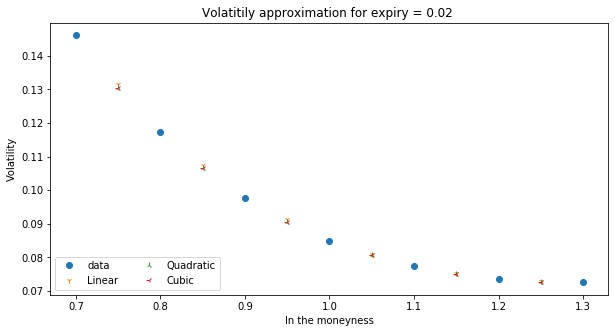

In [440]:
>>> plt.figure(figsize=(10, 5))
>>> plt.plot(expiry_0.itm,expiry_0.sigma, 'o', label='data')
>>> plt.plot(vol_0.itm_new, vol_0.linear, '1', label="Linear")
>>> plt.plot(vol_0.itm_new, vol_0.quadratic,'2',  label="Quadratic")
>>> plt.plot(vol_0.itm_new, vol_0.cubic,'3',  label="Cubic")
>>> plt.legend(loc='lower left', ncol=2)  
>>> plt.xlabel("In the moneyness")
>>> plt.ylabel("Volatility")
>>> plt.title('Volatitily approximation for expiry = 0.02 ')
>>> plt.show()

interpolation schemes in the expiry direction for ITM = 0.7, 0.8, 0.9, 1.1, 1.2, 1.3 for expiries 3 months, 6 years and 9 years

In [16]:
expiry_new = [90/365,6,9]

In [17]:
for i in range(0,len(itm)) : 
    globals()['itm_{0}'.format(i)] = df2.loc[df2.itm == itm[i]]
    f_linear = interpolate.interp1d(globals()['itm_{0}'.format(i)].expiry, globals()['itm_{0}'.format(i)].sigma ,
                                    kind='slinear')
    f_quadratic = interpolate.interp1d(globals()['itm_{0}'.format(i)].expiry,globals()['itm_{0}'.format(i)].sigma ,
                                       kind='quadratic')
    f_cubic = interpolate.interp1d(globals()['itm_{0}'.format(i)].expiry,globals()['itm_{0}'.format(i)].sigma ,
                                   kind='cubic')
    ylinear = f_linear(expiry_new) 
    yquadratic = f_quadratic(expiry_new) 
    ycubic = f_cubic(expiry_new)
    globals()['volex_{0}'.format(i)]= pd.DataFrame(list(zip(globals()['itm_{0}'.format(i)].itm,
                                                            expiry_new,ylinear,yquadratic,ycubic)),
                   columns =['itm','expiry_new','linear', 'quadratic','cubic'])

In [456]:
frames = [volex_0, volex_1, volex_2,volex_3,volex_4,volex_5,volex_6]
result_expiry = pd.concat(frames)

In [457]:
result_expiry

,itm,expiry_new,linear,quadratic,cubic
0,0.7,0.246575,0.133239,0.128732,0.129670
1,0.7,6.000000,0.099880,0.099254,0.099060
2,0.7,9.000000,0.093346,0.093259,0.094346
0,0.8,0.246575,0.111303,0.109545,0.110010
1,0.8,6.000000,0.095554,0.095270,0.095185
2,0.8,9.000000,0.092385,0.092368,0.092868
0,0.9,0.246575,0.096458,0.096559,0.096705
1,0.9,6.000000,0.092627,0.092573,0.092563
2,0.9,9.000000,0.091734,0.091764,0.091867
0,1.0,0.246575,0.086755,0.088071,0.088009


In [458]:
linear_ex = pd.pivot_table(result_expiry, values='linear', index=['itm'],
                    columns=['expiry_new'], aggfunc=np.sum)
quadratic_ex= pd.pivot_table(result_expiry, values='quadratic', index=['itm'],
                    columns=['expiry_new'], aggfunc=np.sum)
cubic_ex = pd.pivot_table(result_expiry, values='cubic', index=['itm'],
                    columns=['expiry_new'], aggfunc=np.sum)

In [461]:
linear_ex.to_excel("output.xlsx")

In [434]:
quadratic_ex

expiry_new,0.25,6.00,9.00
itm,,,
0.7,0.128710,0.099254,0.093259
0.8,0.109531,0.095270,0.092368
0.9,0.096552,0.092573,0.091764
1.0,0.088068,0.090811,0.091370
1.1,0.082938,0.089745,0.091131
1.2,0.080364,0.089211,0.091012
1.3,0.079775,0.089088,0.090984


In [435]:
cubic_ex

expiry_new,0.25,6.00,9.00
itm,,,
0.7,0.129627,0.099060,0.094346
0.8,0.109989,0.095185,0.092868
0.9,0.096699,0.092563,0.091867
1.0,0.088012,0.090849,0.091213
1.1,0.082759,0.089812,0.090818
1.2,0.080124,0.089292,0.090619
1.3,0.079521,0.089173,0.090574


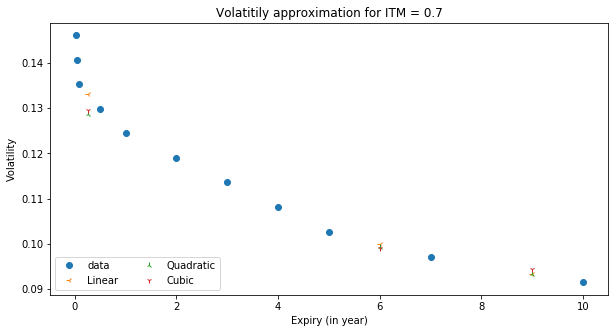

In [441]:
>>> plt.figure(figsize=(10, 5))
>>> plt.plot(itm_0.expiry,itm_0.sigma, 'o', label='data')
>>> plt.plot(volex_0.expiry_new, volex_0.linear,'3',  label="Linear")
>>> plt.plot(volex_0.expiry_new, volex_0.quadratic,'2',  label="Quadratic")
>>> plt.plot(volex_0.expiry_new, volex_0.cubic,'1',  label="Cubic")
>>> plt.legend(loc='lower left', ncol=2)  
>>> plt.xlabel("Expiry (in year)")
>>> plt.ylabel("Volatility")
>>> plt.title('Volatitily approximation for ITM = 0.7')
>>> plt.show()